In [1]:
!pip install pmdarima


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm

# Load Data

In [3]:
# TODO: Load data here.
train = pd.read_csv('hw3_Data2/train.csv', delimiter = '\t', header = None).to_numpy()[1:]
test = pd.read_csv('hw3_Data2/test.csv', delimiter = ' ', header = None).to_numpy()[1:]

In [4]:
#train: ['Date,Open,High,Low,Close,Adj Close,Volume']
print(train.shape)

(225, 1)


In [5]:
#test: ['Date,Open,High,Low,Close,Adj' 'Close,Volume']
print(test.shape)

(21, 2)


In [6]:
arima_data = np.zeros((225,1))
index = []
for i in range(225):
    str_data = train[i][0]
    data = str_data.split(',')
    index.append(data[0])
    arima_data[i] = data[5]

([<matplotlib.axis.XTick at 0x1666ff89610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

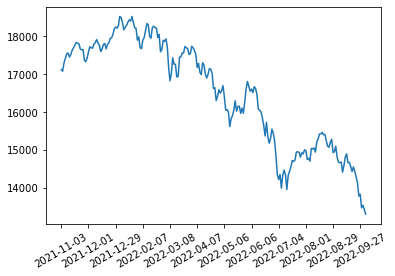

In [7]:
plt.figure()
plt.plot(index,arima_data)
plt.xticks(index[::20],rotation=30)

# ETS Decomposition Models(error-trend-seasonality)

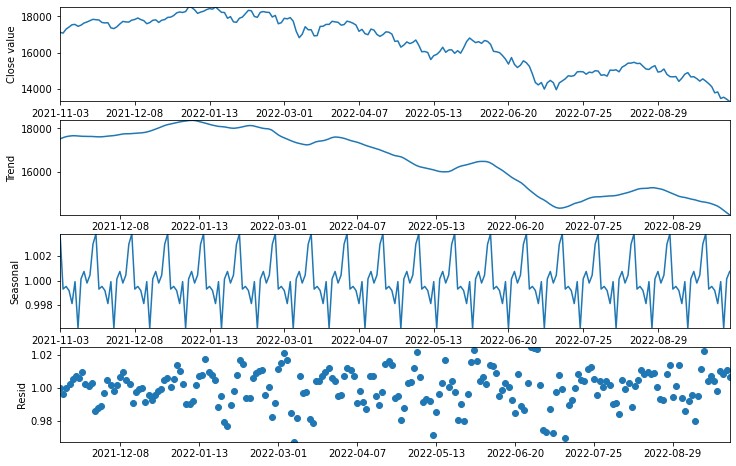

In [8]:
result = seasonal_decompose(arima_data, model='multiplicative', period=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(index,result.observed, label='stock close value')
plt.ylabel('Close value')
plt.xticks(index[::25], rotation=0)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(index,result.trend)
plt.ylabel('Trend')
plt.xticks(index[::25], rotation=0)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(index,result.seasonal)
plt.ylabel('Seasonal')
plt.xticks(index[::25], rotation=0)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(index,result.resid);
plt.ylabel('Resid')
plt.xticks(index[::25], rotation=0)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

# check stationary : Dickey Fuller test

In [9]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #judgement
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                   0.296756
p-value                          0.977195
#Lags Used                       0.000000
Number of Observations Used    224.000000
Criterical Value (1%)           -3.459885
Criterical Value (5%)           -2.874531
Criterical Value (10%)          -2.573694
dtype: float64
The data is non-stationary, so do differencing!


# do  1st-order differential to make it staionary

Results of Dickey-Fuller Test
Test Statistic                 -25.283578
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    224.000000
Criterical Value (1%)           -3.459885
Criterical Value (5%)           -2.874531
Criterical Value (10%)          -2.573694
dtype: float64
The data is stationary. (Criterical Value 1%)


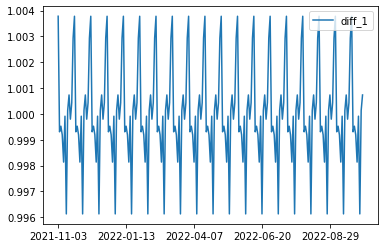

In [10]:
diff_1 = arima_data - np.roll(arima_data,1)
plt.plot(index,result.seasonal,label='diff_1')
plt.xticks(index[::50], rotation=0)
plt.legend();

adf_test(diff_1)

# ACF and PACF

C:\Users\harry\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


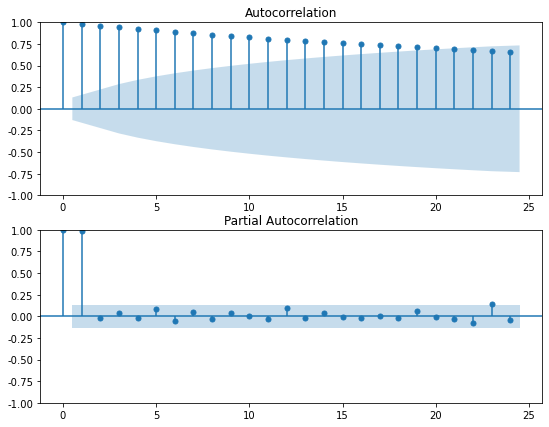

In [11]:
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1);
ax2 = f.add_subplot(212);
plot_pacf(arima_data, lags=24, ax=ax2);
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

# Hence we need a ARMA model

In [12]:
# train_data = np.zeros((225,))
# arima_data = np.zeros((225,))
# test_data = np.zeros((21,1))
# x = []
# for i in range(225):
#     str_train = train[i][0]
#     data = str_train.split(',')
#     x.append(data[0])
#     train_data[i] = data[5]
    
# #     data = str_train.split(',')
#     arima_data[i] = diff_1[i][0]
# arima_data = arima_data[1:]

# for i in range(21):
#     str_test = test[i][0]
#     data = str_test.split(',')
#     x.append(data[0])
#     test_data[i] = data[5]

# # Fit your model
# model = pm.auto_arima(train_data,seasonal=True,m=12)

# # make your forecasts

# forecasts=model.predict(test_data.shape[0]+1)
# # for i in range(test_data.shape[0]+1):
# #     forecasts.append(model.predict(1))
# #     model.update(forecasts[-1])
# print(forecasts)

# predicts = forecasts
# # predicts = []
# # for i in range(21):
# #     if i==0:
# #         predicts.append(train_data[-1]+forecasts[i])
# #     else:
# #         predicts.append(predicts[-1]+forecasts[i])
# # Visualize the forecasts (blue=train, green=forecasts)
# plt.plot(x[:225], train_data, c='blue',label='train')
# plt.plot(x[225:], predicts[1:], c='green',label='predicts')
# plt.plot(x[225:], test_data, c='red',label='test')
# plt.xticks(x[::10], rotation=90)
# plt.legend()
# plt.show()

# start building a ARIMA model(with update)

In [13]:
# train_data = np.zeros((225,))
# arima_data = np.zeros((225,))
# test_data = np.zeros((21,1))
# x = []
# for i in range(225):
#     str_train = train[i][0]
#     data = str_train.split(',')
#     x.append(data[0])
#     train_data[i] = data[5]
    
# #     data = str_train.split(',')
#     arima_data[i] = diff_1[i][0]
# arima_data = arima_data[1:]

# for i in range(21):
#     str_test = test[i][0]
#     data = str_test.split(',')
#     x.append(data[0])
#     test_data[i] = data[5]

# #split the data
# training_data = train_data[:-20]
# valid_data = train_data[-20:]

# # Fit your model
# model = pm.auto_arima(training_data,start_p=0,start_q=0,test='adf',start_P=0,D=1,trace=True,seasonal=True,m=12,err_action='ignore',stepwise=False)

# # make your forecasts
# for i in range(20):
#     valid = model.predict(1)
#     print(valid)
#     model.update(valid_data[i])

# forecasts=model.predict(test_data.shape[0]+1)
# # for i in range(test_data.shape[0]+1):
# #     forecasts.append(model.predict(1))
# #     model.update(forecasts[-1])
# print(forecasts)

# predicts = forecasts
# # predicts = []
# # for i in range(21):
# #     if i==0:
# #         predicts.append(train_data[-1]+forecasts[i])
# #     else:
# #         predicts.append(predicts[-1]+forecasts[i])
# # Visualize the forecasts (blue=train, green=forecasts)
# plt.plot(x[:225], train_data, c='blue',label='train')
# plt.plot(x[225:], predicts[1:], c='green',label='predicts')
# plt.plot(x[225:], test_data, c='red',label='test')
# plt.xticks(x[::10], rotation=90)
# plt.legend()
# plt.show()

In [14]:
# model.summary()

In [15]:
# print(mean_squared_error(np.concatenate((train_data[-1:],np.reshape(test_data,(21,)))),forecasts))
# print(mean_squared_error(test_data,forecasts[1:]))

# start building a ARIMA model(without update) 

In [16]:
# train_data = np.zeros((225,))
# arima_data = np.zeros((225,))
# test_data = np.zeros((21,1))
# x = []
# for i in range(225):
#     str_train = train[i][0]
#     data = str_train.split(',')
#     x.append(data[0])
#     train_data[i] = data[5]
    
# #     data = str_train.split(',')
#     arima_data[i] = diff_1[i][0]
# arima_data = arima_data[1:]

# for i in range(21):
#     str_test = test[i][0]
#     data = str_test.split(',')
#     x.append(data[0])
#     test_data[i] = data[5]

# # Fit your model
# model = pm.auto_arima(train_data,start_p=0,start_q=0,test='adf',start_P=0,D=1,d=None,seasonal=True,m=12,err_action='ignore',stepwise=False)

# # make your forecasts

# forecasts=model.predict(test_data.shape[0]+1)
# # for i in range(test_data.shape[0]+1):
# #     forecasts.append(model.predict(1))
# #     model.update(forecasts[-1])
# print(forecasts)

# predicts = forecasts
# # predicts = []
# # for i in range(21):
# #     if i==0:
# #         predicts.append(train_data[-1]+forecasts[i])
# #     else:
# #         predicts.append(predicts[-1]+forecasts[i])
# # Visualize the forecasts (blue=train, green=forecasts)
# plt.plot(x[:225], train_data, c='blue',label='train')
# plt.plot(x[225:], predicts[1:], c='green',label='predicts')
# plt.plot(x[225:], test_data, c='red',label='test')
# plt.xticks(x[::10], rotation=90)
# plt.legend()
# plt.show()

In [17]:
# model.summary()

In [18]:
# print(mean_squared_error(np.concatenate((train_data[-1:],np.reshape(test_data,(21,)))),forecasts))

In [19]:
# print(forecasts)

In [20]:
# plt.plot(arima_data)

In [21]:
# print(test_data.shape[0])

In [22]:
# from pmdarima.model_selection import train_test_split
# # Load/split your data
# y = pm.datasets.load_wineind()
# train0, test0 = train_test_split(y, train_size=150)

# # Fit your model
# model = pm.auto_arima(train, seasonal=True, m=12)

# # make your forecasts
# forecasts = model.predict(test.shape[0])  # predict N steps into the future

# # Visualize the forecasts (blue=train, green=forecasts)
# x = np.arange(y.shape[0])
# plt.plot(x[:150], train0, c='blue')
# plt.plot(x[150:], forecasts, c='green')
# plt.show()

In [23]:
# plt.plot(x[:150], train, c='blue')
# plt.plot(x[150:], forecasts, c='green')
# plt.plot(x[150:],test, c='red')
# plt.show()

In [24]:
# print(train_data.shape)

In [25]:
def arima_mse(data, p=4, d=3, q=4):
    best_para =["pdqlmn",200000]
    #split data
    train = train_data[:]
#     test = np.concatenate((train_data[-3:],np.reshape(test_data,(21,))))
    test = np.reshape(test_data,(21,))
    mse_r = []
    name = []
    for i in range(p):
        for j in range(1,3):
            for k in range(q):  
                for l in range(p):
                    for m in range(1,3):
                        for n in range(q):
                            try:
                                model = pm.ARIMA(order=(i,j,k),seasonal_order=(l,m,n,12),out_of_sample_size=20)
                                model.fit(train)
                                fc = model.predict(21)
                                mse = mean_squared_error(test,fc)
                                mse_r.append(mse)
                                name.append(f"ARIMA({i},{j},{k},{l},{m},{n})")
                                print(f"ARIMA({i},{j},{k},{l},{m},{n})：MSE={mse}")
                                if mse < best_para[1]:
                                    best_para[0] = f"ARIMA({i},{j},{k},{l},{m},{n})"
                                    best_para[1] = mse
                            except:
                                print(f"ARIMA({i},{j},{k},{l},{m},{n})",'is wrong')
                                mse_r.append(200000)
                                name.append(f"ARIMA({i},{j},{k},{l},{m},{n})")
                                continue
    print("==========================================================================")
    print(f"This best model is {best_para[0]} based on argmin MSE.")
    plt.figure(figsize=(12,5))
    plt.bar(name, mse_r)
    plt.bar(best_para[0], best_para[1], color = "red")
    plt.xticks(name[::20],rotation=30)
    plt.title("MSE")
    plt.savefig("Arima MSE")
    plt.show()
    return best_para
best_para = arima_mse(arima_data)

In [26]:
train_data = np.zeros((225,))
arima_data = np.zeros((225,))
test_data = np.zeros((21,1))
x = []
for i in range(225):
    str_train = train[i][0]
    data = str_train.split(',')
    x.append(data[0])
    train_data[i] = data[5]
    
#     data = str_train.split(',')
#     arima_data[i] = diff_1[i][0]
# arima_data = arima_data[1:]

for i in range(21):
    str_test = test[i][0]
    data = str_test.split(',')
    x.append(data[0])
    test_data[i] = data[5]

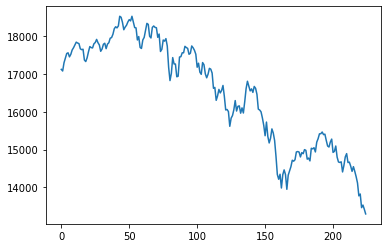

In [27]:
plt.plot(train_data)

In [28]:
model = pm.ARIMA(order=(2,2,3),seasonal_order=(2,1,0,12),out_of_sample_size=20)
model.fit(train_data)
predicts = model.predict(21)

C:\Users\harry\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\harry\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


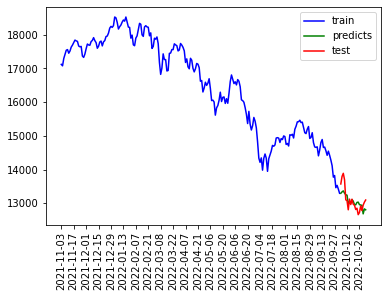

In [29]:
plt.plot(x[:225], train_data, c='blue',label='train')
plt.plot(x[225:], predicts, c='green',label='predicts')
plt.plot(x[225:], test_data, c='red',label='test')
plt.xticks(x[::10], rotation=90)
plt.legend()
plt.show()

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  225
Model:             SARIMAX(2, 2, 3)x(2, 1, [], 12)   Log Likelihood               -1439.836
Date:                             Tue, 15 Nov 2022   AIC                           2897.671
Time:                                     20:02:40   BIC                           2927.838
Sample:                                          0   HQIC                          2909.865
                                             - 225                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4734      1.052      1.401      0.161      -0.588       3.534
ar.L1         -1.1086      0.079    -13.999      0.000      -1.264      -0.953
ar.L2         -0.9245      0.080    -11.529      0.000      -1.082      -0.767
ma.L1          0.1846      5.556      0.033      0.973     -10.704      11.073
ma.L2         -0.2399      6.557     -0.037      0.971     -13.091      12.611
ma.L3         -0.9446      5.236     -0.180      0.857     -11.207       9.318
ar.S.L12      -0.5594      0.075     -7.474      0.000      -0.706      -0.413
ar.S.L24      -0.2757      0.092     -3.005      0.003      -0.455      -0.096
sigma2      5.136e+04   2.84e+05      0.181      0.856   -5.04e+05    6.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.06   Prob(JB):                         0.27
Heteroskedasticity (H):               1.08   Skew:                            -0.19
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
print(mean_squared_error(test_data,predicts))
print(train_data[-1],predicts[0])

60449.52553029907
13300.480469 13299.580733610797


In [32]:
print(best_para)
# (np.concatenate((train_data[-2:],np.reshape(test_data,(21,))))).shape
# print(np.reshape(test_data,(21,)).shape)
# print(train_data[-2:].shape)

NameError: name 'best_para' is not defined

# New: Without data trans., searching arima_mse(arima_data, 4,3,4),

# New: We found 'ARIMA(3,1,2,3,2,1)', 60895.79786192435 is best

# add out_of_sample_size=20

# We found 'ARIMA(2,2,3,2,1,0)', 60449.52553029907 is best

# data transformation

# We found 'ARIMA(2,1,1,2,2,3)', 71914.75876944764 is best

# Old: Without data trans., searching arima_mse(arima_data, 5,3,5),

# Old:We found 'ARIMA(1,1,1,3,2,1)', 53728.12632960215 is best

And there are Non-stationary starting autoregressive parameters found. Using zeros as starting parameters and 

Non-invertible starting MA parameters found. Using zeros as starting parameters.

ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals problems

# try some data trans., (data/10000 - 0.966)*3, then data are scaled to 1.多


# We found 'ARIMA(2,1,1,2,2,3)', 0.006472328289250267 is best

In [ ]:
# train_data = np.zeros((225,))
# arima_data = np.zeros((225,))
# test_data = np.zeros((21,1))
# x = []
# for i in range(225):
#     str_train = train[i][0]
#     data = str_train.split(',')
#     x.append(data[0])
#     train_data[i] = data[5]
    
# #     data = str_train.split(',')
#     arima_data[i] = diff_1[i][0]
# arima_data = arima_data[1:]

# for i in range(21):
#     str_test = test[i][0]
#     data = str_test.split(',')
#     x.append(data[0])
#     test_data[i] = data[5]

# train_data = (train_data/10000-0.966)*3
# test_data = (test_data/10000-0.966)*3

In [ ]:
def arima_mse_V(train_data,test_data, p=4, d=3, q=4):
    best_para =["pdqlmn",10000]
    #split data
    train = train_data[:]
#     test = np.concatenate((train_data[-3:],np.reshape(test_data,(21,))))
    test = np.reshape(test_data,(21,))
    mse_r = []
    name = []
    for i in range(p):
        for j in range(1,3):
            for k in range(q):  
                for l in range(p):
                    for m in range(1,3):
                        for n in range(q):
                            try:
                                model = pm.ARIMA(order=(i,j,k),seasonal_order=(l,m,n,12),out_of_sample_size=20)
                                model.fit(train)
                                fc = model.predict(21)
                                mse = mean_squared_error(test,fc)
                                mse_r.append(mse)
                                name.append(f"ARIMA({i},{j},{k},{l},{m},{n})")
                                print(f"ARIMA({i},{j},{k},{l},{m},{n})：MSE={mse}")
                                if mse < best_para[1]:
                                    best_para[0] = f"ARIMA({i},{j},{k},{l},{m},{n})"
                                    best_para[1] = mse
                            except:
                                print(f"ARIMA({i},{j},{k},{l},{m},{n})",'is wrong')
                                mse_r.append(10000)
                                name.append(f"ARIMA({i},{j},{k},{l},{m},{n})")
                                continue
    print("==========================================================================")
    print(f"This best model is {best_para[0]} based on argmin MSE.")
    plt.figure(figsize=(12,5))
    plt.bar(name, mse_r)
    plt.bar(best_para[0], best_para[1], color = "red")
    plt.xticks(name[::20],rotation=30)
    plt.title("MSE")
    plt.savefig("Arima MSE")
    plt.show()
    return best_para
# best_para = arima_mse_V(train_data,test_data)

In [ ]:
# print(best_para)

In [ ]:
# model = pm.ARIMA(order=(2,1,1),seasonal_order=(2,2,3,12),out_of_sample_size=20)
# model.fit(train_data)
# predicts = model.predict(21)

In [ ]:
# restored_train_data = (train_data/3+0.966)*10000
# retored_predict_data = (predicts/3+0.966)*10000
# restored_test_data = (test_data/3+0.966)*10000

In [ ]:
# plt.plot(x[:225], restored_train_data[:], c='blue',label='train')
# plt.plot(x[225:], retored_predict_data, c='green',label='predicts')
# plt.plot(x[225:], restored_test_data, c='red',label='test')
# plt.xticks(x[::10], rotation=90)
# plt.legend()
# plt.show()

In [ ]:
# model.summary()

In [ ]:
# print(mean_squared_error(retored_predict_data,restored_test_data))